In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2023-05-19 22:59:46.393923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 22:59:48.129863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# augment data shape to include channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
input_shape = x_train.shape[1:]
latent_dim = 16

In [5]:
encoder_input = layers.Input(shape=input_shape, name='encoder_input')
# x = layers.Flatten()(encoder_input_concat)
encoder_label_input = layers.Input(shape=(10,), name='encoder_label_input')
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_input)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# concatenate the label input with the flattened convolutional layer
x = layers.concatenate([x, encoder_label_input])
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

encoder = Model([encoder_input, encoder_label_input], [z_mean, z_log_var], name='encoder')
print(encoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 12544)        0           ['conv2d_1[0][0]']               
                                                                                            

2023-05-19 22:59:51.261407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 22:59:51.343342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 22:59:51.343667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 dense (Dense)                  (None, 128)          1607040     ['concatenate[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 16)           2064        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 16)           2064        ['dense[0][0]']                  
                                                                                                  
Total params: 1,629,984
Trainable params: 1,629,984
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [6]:
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
decoder_label_input = layers.Input(shape=(10,), name='decoder_label_input')
x = layers.concatenate([decoder_input, decoder_label_input])
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = Model([decoder_input, decoder_label_input], decoder_output, name='decoder')

print(decoder.summary())

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 16)]         0           []                               
                                                                                                  
 decoder_label_input (InputLaye  [(None, 10)]        0           []                               
 r)                                                                                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 26)           0           ['decoder_input[0][0]',          
                                                                  'decoder_label_input[0][0]']    
                                                                                            

In [8]:
x = layers.Input(shape=input_shape)
label = layers.Input(shape=(10,))
z_mean, z_log_var = encoder([x, label])
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded = decoder([z, label])

cvae = Model([x, label], x_decoded, name='cvae')
print(cvae.summary())

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 16),         1629984     ['input_1[0][0]',                
                                 (None, 16)]                      'input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 16)           0           ['encoder[0][0]',             

In [9]:
recon_loss = tf.keras.metrics.binary_crossentropy(K.flatten(x), K.flatten(x_decoded))
kl_loss = -5e-4 * K.mean(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
cvae_loss = K.mean(recon_loss + kl_loss)
cvae.add_loss(cvae_loss)

In [10]:
batch_size = 32
epochs = 30

In [11]:
cvae.compile(optimizer='adam')

In [12]:
cvae.fit([x_train, y_train],None,epochs=epochs,batch_size=batch_size,validation_data=([x_test, y_test], None))

2023-05-19 22:59:53.673679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-05-19 22:59:53.896051: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/30


2023-05-19 22:59:56.482107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-19 22:59:57.256843: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 22:59:57.819585: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f45ecd0c040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-19 22:59:57.819623: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-05-19 22:59:57.827979: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-19 22:59:57.951851: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 22:59:58.034813: I ./tensorflow/compiler/jit/device_comp

1875/1875 [==============================] - 27s 11ms/step - loss: 0.1306 - val_loss: 0.0964
Epoch 2/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0928 - val_loss: 0.0902
Epoch 3/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0887 - val_loss: 0.0875
Epoch 4/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0868 - val_loss: 0.0858
Epoch 5/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0855 - val_loss: 0.0854
Epoch 6/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0846 - val_loss: 0.0847
Epoch 7/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0840 - val_loss: 0.0843
Epoch 8/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0835 - val_loss: 0.0841
Epoch 9/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0830 - val_loss: 0.0836
Epoch 10/30
1875/1875 [==============================] - 19s 10ms/step - lo

In [13]:
decoded_imgs = cvae.predict([x_test, y_test])

313/313 [==============================] - 1s 4ms/step


In [14]:
# plot n random decoded images
def plot(n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        idx = np.random.randint(0, len(x_test))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

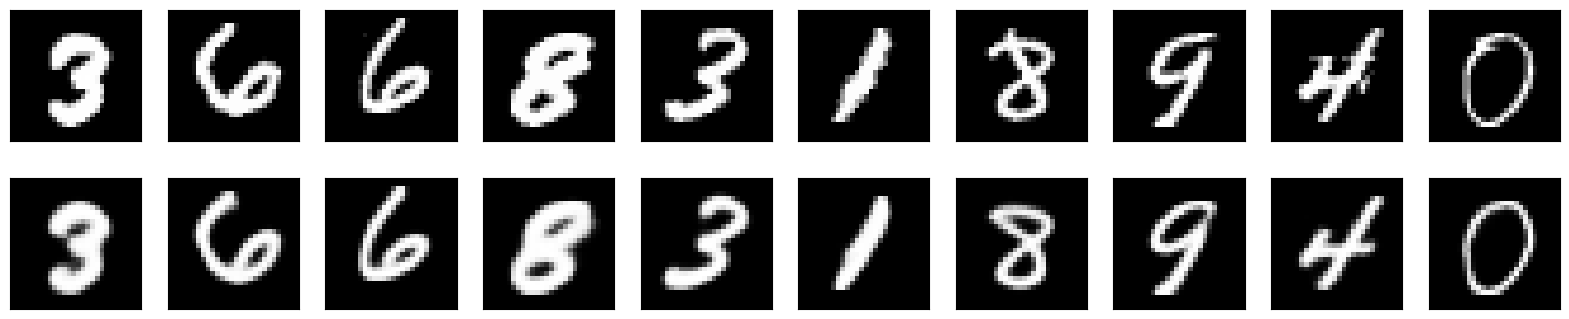

In [15]:
plot(10)